In [1]:
import pandas as pd
import spacy
from sentence_transformers import SentenceTransformer
import umap
import hdbscan
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
from keybert import KeyBERT

c:\Users\gaura\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
file_path = "Air India flight crashes in Ahmedabad India video details.csv"  # change if needed
df = pd.read_csv(file_path, encoding='latin1')

# Check columns
print("Columns:", df.columns.tolist())

# Combine useful text fields
text_fields = ["title", "keywords", "shortDescription"]
df["combined_text"] = df[text_fields].fillna("").agg(". ".join, axis=1)

Columns: ['videoId', 'title', 'lengthSeconds', 'keywords', 'shortDescription', 'allowRatings', 'viewCount', 'author', 'isPrivate']


In [5]:
!python -m spacy download en_core_web_sm


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
      --------------------------------------- 0.3/12.8 MB ? eta -:--:--
     - -------------------------------------- 0.5/12.8 MB 1.5 MB/s eta 0:00:09
     -- ------------------------------------- 0.8/12.8 MB 1.9 MB/s eta 0:00:07
     ---- ----------------------------------- 1.6/12.8 MB 2.1 MB/s eta 0:00:06
     ------ --------------------------------- 2.1/12.8 MB 2.2 MB/s eta 0:00:05
     -------- ------------------------------- 2.6/12.8 MB 2.3 MB/s eta 0:00:05
     ---------- ----------------------------- 3.4/12.8 MB 2.5 MB/s eta 0:00:04
     ------------- -------------------------- 4.2/12.8 MB 2.6 MB/s eta 0:00:04
     -------------- ------------------------- 4.7/12.8 MB 2.6 MB/s eta 0:00:04
     ---------------- ----------------------- 5.2/12.8 MB 2.7 MB/s eta 0:00:03
     ------------------ --------------------- 6.0/12.8 MB 2.8 MB/s eta 0:00:03
     ------------------- -------------------- 6.3/12.8 MB 2.8 MB/

In [6]:
nlp = spacy.load("en_core_web_sm", disable=["ner","tagger"])

sentences = []
meta = []

for idx, row in df.iterrows():
    doc = nlp(row["combined_text"])
    for s in doc.sents:
        s_text = s.text.strip()
        if len(s_text.split()) >= 3:  # filter very short sentences
            sentences.append(s_text)
            meta.append({"videoId": row["videoId"], "title": row["title"]})

print(f"Total sentences extracted: {len(sentences)}")

c:\Users\gaura\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\pipeline\lemmatizer.py:188: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Total sentences extracted: 1137


In [7]:
model = SentenceTransformer("all-mpnet-base-v2")
embeddings = model.encode(sentences, batch_size=64, show_progress_bar=True, normalize_embeddings=True)

c:\Users\gaura\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\gaura\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not inst

In [8]:
umap_emb = umap.UMAP(n_neighbors=15, min_dist=0.0, n_components=20, metric='cosine').fit_transform(embeddings)

In [9]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=5, metric='euclidean', cluster_selection_method='eom')
labels = clusterer.fit_predict(umap_emb)

print("Clusters found:", len(set(labels)) - (1 if -1 in labels else 0))


Clusters found: 64


In [10]:
df_sent = pd.DataFrame({
    "sentence": sentences,
    "cluster": labels,
    "videoId": [m["videoId"] for m in meta],
    "title": [m["title"] for m in meta]
})

In [11]:
cluster_labels = {}

# TF-IDF labeling
for c in sorted(df_sent["cluster"].unique()):
    if c == -1:
        continue  # skip noise
    cluster_sents = df_sent[df_sent.cluster == c]["sentence"].tolist()
    tf = TfidfVectorizer(stop_words='english', ngram_range=(1,2), max_features=20)
    X = tf.fit_transform(cluster_sents)
    top_terms = [t for t, _ in sorted(zip(tf.get_feature_names_out(), X.mean(axis=0).A1), key=lambda x: -x[1])[:5]]
    cluster_labels[c] = top_terms

In [12]:
df_sent["cluster_label"] = df_sent["cluster"].apply(lambda c: ", ".join(cluster_labels.get(c, ["noise"])) if c != -1 else "noise")

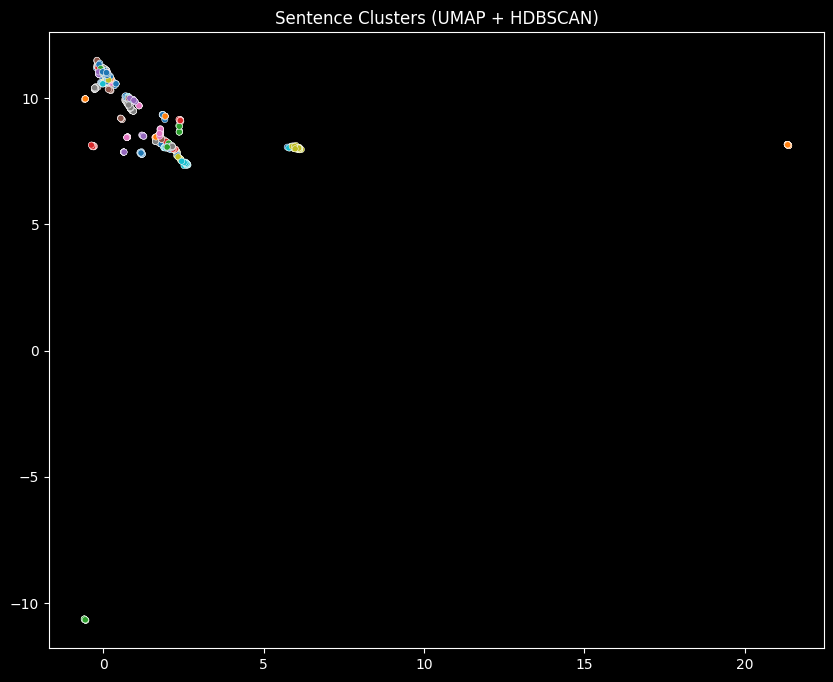

In [13]:
plt.figure(figsize=(10,8))
sns.scatterplot(x=umap_emb[:,0], y=umap_emb[:,1], hue=labels, palette="tab10", s=20, legend=False)
plt.title("Sentence Clusters (UMAP + HDBSCAN)")
plt.show()

In [14]:
df_sent.to_csv("sentence_clusters.csv", index=False)
print("Saved cluster assignments to sentence_clusters.csv")

# Sample output
df_sent.head(20)

Saved cluster assignments to sentence_clusters.csv


,sentence,cluster,videoId,title,cluster_label
0,Air India plane crashes shortly after take off...,-1,7X5jJRx1_r0,Air India plane crashes shortly after take off...,noise
1,Ahmedabad airport AMD; Air India Flight AI147;...,-1,7X5jJRx1_r0,Air India plane crashes shortly after take off...,noise
2,An Air India plane has crashed shortly after t...,62,7X5jJRx1_r0,Air India plane crashes shortly after take off...,"india, ahmedabad, crashed, air, air india"
3,"Air India said on Thursday that Flight AI171, ...",47,7X5jJRx1_r0,Air India plane crashes shortly after take off...,"flight, london, gatwick, incident, london gatwick"
4,Rebecca Bundhun joins us live from Mumbai to d...,7,7X5jJRx1_r0,Air India plane crashes shortly after take off...,"stay, updates, india, latest, latest updates"
5,Subscribe to our channel: http://bit.ly/AJSubs...,29,7X5jJRx1_r0,Air India plane crashes shortly after take off...,"com, https, jagran, dainik, dainik jagran"
6,AI147 #AirIndia147 #AhmedabadAirport #LondonGa...,27,7X5jJRx1_r0,Air India plane crashes shortly after take off...,"new, boeing787, londongatwick, 242, emergencyr..."
7,#DreamlinerCrash #AviationEmergency #FlightSaf...,28,7X5jJRx1_r0,Air India plane crashes shortly after take off...,"airindia, airindiacrash, ahmedabad, breakingne..."
8,Video shows Air India plane crashing in Ahmeda...,57,nFuLfEjvzMU,Video shows Air India plane crashing in Ahmedabad,"crash, ahmedabad, india, air, air india"
9,Airplane Crash; Plane Crash; Boeing 787; CBS N...,6,nFuLfEjvzMU,Video shows Air India plane crashing in Ahmedabad,"crash, plane, plane crash, india, ahmedabad"
